# CIFAR-10

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
transform = transforms.ToTensor()

In [79]:
train_data = datasets.CIFAR10(root="../Data", train=True, download=True,transform=transform)

Files already downloaded and verified


In [80]:
test_data = datasets.CIFAR10(root="../Data", train=False, download=True,transform=transform)

Files already downloaded and verified


In [81]:
torch.manual_seed(102)
train_loader = DataLoader(train_data, batch_size=3, shuffle=True)
test_loader = DataLoader(test_data, batch_size=3, shuffle=False)

In [82]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [83]:
for images, labels in train_loader:
    break

In [84]:
labels

tensor([2, 9, 5])

In [85]:
images.shape

torch.Size([3, 3, 32, 32])

Label: [2 9 5]
Class: [' bird' 'truck' '  dog']


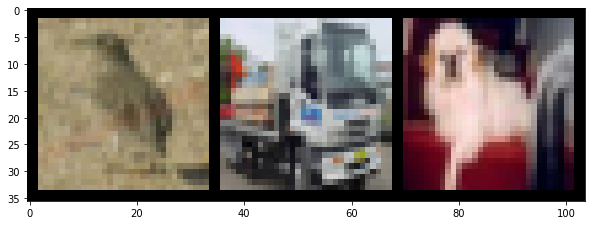

In [86]:
print("Label:", labels.numpy())
print("Class:", np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Creating the model

In [87]:
class Convolutionalnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1) # 3:input channel (3 colors),6: output Channels (filters) (arbitrary),5: Kernel. ,1: Stide
        self.conv2 = nn.Conv2d(6,16,3,1) # 16 and 3 is arbitrary and can be modified for better training performance
        self.fc1 = nn.Linear(6*6*16,120) # Se pytorch lect 68 ca 5 min hur denna räknas ut
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = self.conv1(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = self.conv2(X)
        X = F.relu(X)
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)
        

In [88]:
torch.manual_seed(101)
model = Convolutionalnetwork()
model

Convolutionalnetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [89]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [92]:
import time
start_time = time.time()

# Variables (trackers)
epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0 

    # Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train) # NOTE. No need to flatten as conv2d expect 2d data
        lossTrain = criterion(y_pred, y_train)
        #lossTrain = criterion(y_pred, y_train).data

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0 
        trn_corr += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%600 == 0:
            print(f"EPOCH {i:2} BATCH: {b:4} [{10*b:6}/50000] LOSS: {lossTrain.item()} accuracy: {trn_corr.item()*100/(10*b):7.3}%")
    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_corr)

    # Test (If we feed in test data during traing, how well will it perform)
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

current_time = time.time() 
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH  0 BATCH:  600 [  6000/50000] LOSS: 1.474320411682129 accuracy:    10.9%
EPOCH  0 BATCH: 1200 [ 12000/50000] LOSS: 1.6861225366592407 accuracy:    11.4%
EPOCH  0 BATCH: 1800 [ 18000/50000] LOSS: 0.8157472014427185 accuracy:    11.8%
EPOCH  0 BATCH: 2400 [ 24000/50000] LOSS: 1.188211441040039 accuracy:    12.0%
EPOCH  0 BATCH: 3000 [ 30000/50000] LOSS: 1.4639838933944702 accuracy:    12.2%
EPOCH  0 BATCH: 3600 [ 36000/50000] LOSS: 3.057734489440918 accuracy:    12.3%
EPOCH  0 BATCH: 4200 [ 42000/50000] LOSS: 1.0897340774536133 accuracy:    12.3%
EPOCH  0 BATCH: 4800 [ 48000/50000] LOSS: 1.7162370681762695 accuracy:    12.4%
EPOCH  0 BATCH: 5400 [ 54000/50000] LOSS: 1.8587208986282349 accuracy:    12.5%
EPOCH  0 BATCH: 6000 [ 60000/50000] LOSS: 1.4873228073120117 accuracy:    12.6%
EPOCH  0 BATCH: 6600 [ 66000/50000] LOSS: 1.7962716817855835 accuracy:    12.7%
EPOCH  0 BATCH: 7200 [ 72000/50000] LOSS: 1.6310491561889648 accuracy:    12.8%
EPOCH  0 BATCH: 7800 [ 78000/50000] LOSS: 1

EPOCH  3 BATCH: 13800 [138000/50000] LOSS: 1.3889236450195312 accuracy:    17.6%
EPOCH  3 BATCH: 14400 [144000/50000] LOSS: 0.34324702620506287 accuracy:    17.6%
EPOCH  3 BATCH: 15000 [150000/50000] LOSS: 2.0745255947113037 accuracy:    17.6%
EPOCH  3 BATCH: 15600 [156000/50000] LOSS: 1.8942108154296875 accuracy:    17.5%
EPOCH  3 BATCH: 16200 [162000/50000] LOSS: 0.38924217224121094 accuracy:    17.5%
EPOCH  4 BATCH:  600 [  6000/50000] LOSS: 0.9390604496002197 accuracy:    18.1%
EPOCH  4 BATCH: 1200 [ 12000/50000] LOSS: 0.6415125727653503 accuracy:    18.0%
EPOCH  4 BATCH: 1800 [ 18000/50000] LOSS: 0.6662397384643555 accuracy:    18.1%
EPOCH  4 BATCH: 2400 [ 24000/50000] LOSS: 0.3740178346633911 accuracy:    18.1%
EPOCH  4 BATCH: 3000 [ 30000/50000] LOSS: 0.055320579558610916 accuracy:    18.2%
EPOCH  4 BATCH: 3600 [ 36000/50000] LOSS: 0.5191233158111572 accuracy:    18.3%
EPOCH  4 BATCH: 4200 [ 42000/50000] LOSS: 1.2754267454147339 accuracy:    18.3%
EPOCH  4 BATCH: 4800 [ 48000/50

EPOCH  7 BATCH: 10200 [102000/50000] LOSS: 1.8590649366378784 accuracy:    19.1%
EPOCH  7 BATCH: 10800 [108000/50000] LOSS: 1.021400809288025 accuracy:    19.1%
EPOCH  7 BATCH: 11400 [114000/50000] LOSS: 0.6618285179138184 accuracy:    19.2%
EPOCH  7 BATCH: 12000 [120000/50000] LOSS: 0.9946624636650085 accuracy:    19.2%
EPOCH  7 BATCH: 12600 [126000/50000] LOSS: 0.9177135825157166 accuracy:    19.2%
EPOCH  7 BATCH: 13200 [132000/50000] LOSS: 0.22567622363567352 accuracy:    19.1%
EPOCH  7 BATCH: 13800 [138000/50000] LOSS: 1.3448610305786133 accuracy:    19.1%
EPOCH  7 BATCH: 14400 [144000/50000] LOSS: 0.6753535270690918 accuracy:    19.1%
EPOCH  7 BATCH: 15000 [150000/50000] LOSS: 1.1190760135650635 accuracy:    19.1%
EPOCH  7 BATCH: 15600 [156000/50000] LOSS: 0.3252566158771515 accuracy:    19.1%
EPOCH  7 BATCH: 16200 [162000/50000] LOSS: 1.100185513496399 accuracy:    19.1%
EPOCH  8 BATCH:  600 [  6000/50000] LOSS: 0.6877951622009277 accuracy:    19.8%
EPOCH  8 BATCH: 1200 [ 12000/5

## Save the model

In [95]:
torch.save(model.state_dict(),"MyCIFAR.pt")

## Evaluate performance

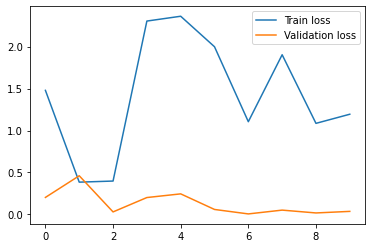

In [96]:
#Evaluate performance
plt.plot(train_losses,label="Train loss")
plt.plot(test_losses, label="Validation loss")
plt.legend()

## Accuracy

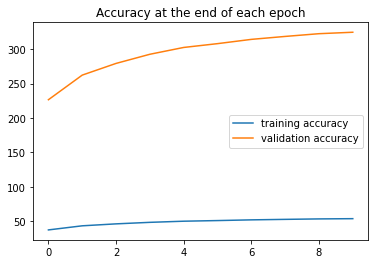

In [97]:
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in train_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

## Test on unseen dataset

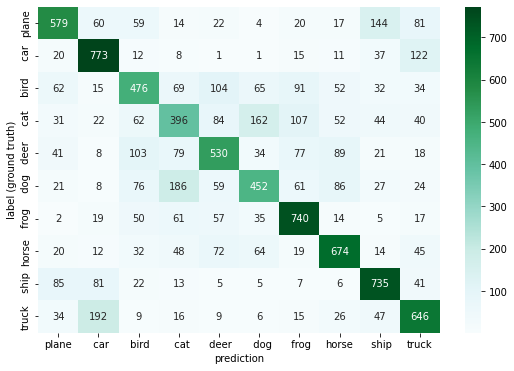

In [99]:
## Create loader

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        break
        
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()


In [101]:
len(predicted)

10000

In [27]:
predicted.view(-1)[0:2]

tensor([3, 8])

In [28]:
confusion_matrix(y_test.view(-1)[0:2], predicted.view(-1)[0:2])

array([[1, 0],
       [0, 1]])

In [75]:
arr

array([[491,  30,  40,  61,  42,  12,  21,  20, 204,  79],
       [ 17, 653,   7,  37,   9,   5,  35,  12,  48, 177],
       [ 60,  12, 212, 130, 235, 160,  92,  34,  40,  25],
       [ 14,  11,  20, 474,  78, 215, 116,  35,  18,  19],
       [ 32,   4,  26, 111, 526,  86, 103,  73,  21,  18],
       [  7,   6,  25, 224,  68, 541,  54,  50,  12,  13],
       [  7,   9,  14,  88, 102,  52, 693,  15,   6,  14],
       [ 13,   2,  16, 100,  67, 130,  27, 600,   5,  40],
       [ 55,  45,   7,  31,  10,   9,  17,  12, 754,  60],
       [ 33, 142,   4,  47,   8,  18,  29,  23,  48, 648]])